# Gather insights from the experiments run on GCP

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from common.utils import check_missing_experiments, join_df

## Merge the experiments

In [10]:
df = join_df('./results/lenet/results/1/')

## Read the experiments file

In [ ]:
experiment_file = './resnet_36exp.pkl'
df = pd.read_pickle(experiment_file)

df.head()



### Create new columns for representation

- Final accuracy
- Total time taken
- Parallelism

In [11]:
# Set the acc to the final accuracy
df['acc'] = df.accuracy.map(lambda a: a[-1])

# Set the time to the sum of the epoch durations
df['time'] = df.epoch_duration.map(lambda t: t[-1])

# Set the parallelism to the first since it is constant
df.parallelism = df.parallelism.map(lambda l:l[0])

# change -1 to inf so the order is right in the plot
df.k = df.k.map(lambda val: float('inf') if val == -1 else val)

df['global_batch'] = df.batch_size * df.parallelism



In [ ]:
from typing import List

def accum_time(durations: List[float]):
    # print('before', durations)
    for i in range(1, len(durations)):
        durations[i] += durations[i-1]
    return durations
        
df.epoch_duration.map(lambda durs: accum_time(durs))
        

### Plot the Correlations between the K, Batch and Parallelism with time and accuracy

<AxesSubplot:>

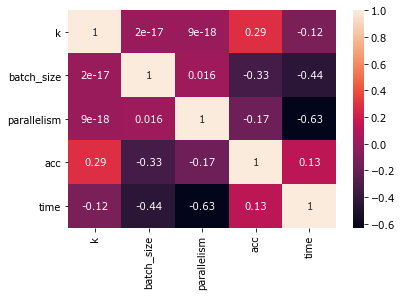

In [12]:
sns.set_palette('Set1')

corr = df[['k', 'batch_size', 'parallelism', 'acc', 'time']].corr()
sns.heatmap(corr,
            annot=True,
)

# plt.savefig('./figures/resnet34/heat.png', dpi=300)


In [ ]:
df.sort_values('time')


### Get the max accuracies and times and check the parameters used

In [14]:
# get the max accuracies
df[['k', 'parallelism', 'acc','batch_size','time']].sort_values(by='time', ascending=True)

,k,parallelism,acc,batch_size,time
52,inf,4,98.88,128,62.385761
4,32.0,4,89.21,128,64.844356
33,inf,8,89.10,128,68.545942
8,32.0,8,80.32,128,68.623375
21,16.0,4,79.22,128,68.749641
...,...,...,...,...,...
56,32.0,1,89.32,16,653.229728
13,inf,1,98.78,16,669.929633
48,inf,1,98.91,16,671.920724
10,16.0,1,99.15,16,715.945094


## Which of the parameter combinations offer a better bang for the buck

In [ ]:
m = df.loc[df.acc>10].groupby(['k', 'global_batch']).mean()
m['rate'] = m['acc']/m['time']
m.sort_values('rate', ascending=False)[['batch_size','acc', 'time', 'rate']]

## Calculate TTA with different accuracies



In [38]:
# Calculate time to accuracy for different accuracies
def tta_crossbow(acc:int, df: pd.DataFrame):
    """Computes the tta as in the crossbow paper
    where the tta is the median of the last 5 epochs"""

    res = []
    for _, row in df.iterrows():
        done = False
        dur, accuracy = row.epoch_duration, row.accuracy
        for idx, (t, a) in enumerate(zip(dur, accuracy[:len(dur)])):
            
            # if there are less than 5 elements behind, continue
            if idx < 4:
                continue
                
            # calculate the median of the next five elements
            if np.median(accuracy[idx - 4:idx+1]) >= acc:
                res.append(t)
                done = True
                break

        if not done:
            res.append(np.nan)

    return res


def tta(acc:int, df:pd.DataFrame):
    
    
    res = []
    for _, row in df.iterrows():
        done=False
        dur, accuracy = row.epoch_duration, row.accuracy
        for idx, (t, a) in enumerate(zip(dur, accuracy[:len(dur)])):
            if a >= acc:
                res.append(t)
                done = True
                break

        if not done:
            res.append(np.nan)

    return res
        

In [41]:

df['tta_99'] = tta(99, df)
df['tta_cross_99'] = tta_crossbow(99, df)



df.sort_values('tta_cross_99')[['k', 'batch_size', 'parallelism', 'tta_cross_99']].head()


,k,batch_size,parallelism,tta_cross_99
22,inf,16,8,38.452510
32,32.0,16,8,46.129413
12,32.0,32,8,54.170666
63,inf,32,8,59.887549
60,inf,32,4,63.453669


<AxesSubplot:xlabel='parallelism', ylabel='tta_99'>

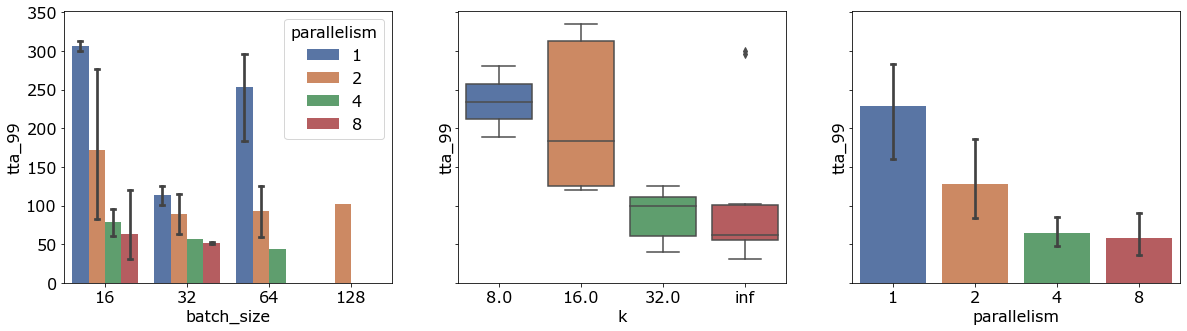

In [49]:
f, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 5))
sns.barplot(x='batch_size', y='tta_99', hue='parallelism', data=df, ax=ax[0], capsize=.05)
sns.boxplot(x='k', y='tta_99', data=df, ax=ax[1])
sns.barplot(x='parallelism', y='tta_99', data=df ,ax=ax[2] ,capsize=.05)


# sns.barplot(x='k', y='tta_99', data=df)

In [42]:
df.head(10)
sns.set_palette('deep', 10)

### Plot the distributions of time and accuracy as a function of K, Batch and parallelism

#### Plot the accuracy as a factor

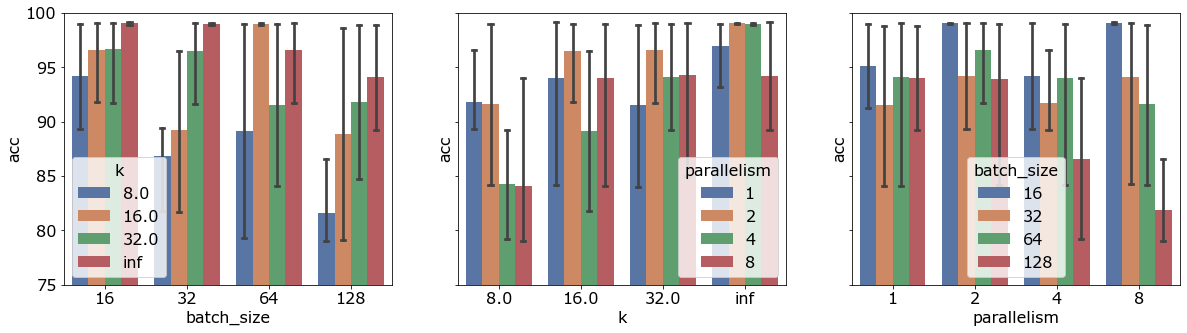

In [48]:
f, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 5))
sns.barplot(x='batch_size', y='acc', hue='k', data=df, ax=ax[0], capsize=.05)
sns.barplot(x='k', y='acc', data=df, ax=ax[1], capsize=.05, hue='parallelism')
sns.barplot(x='parallelism', y='acc', data=df, hue='batch_size' ,ax=ax[2] ,capsize=.05)

for a in ax:
    a.set_ylim([75, 100])



# plt.savefig('./figures/resnet34/accuracy.png', dpi=300)

<AxesSubplot:xlabel='k', ylabel='acc'>

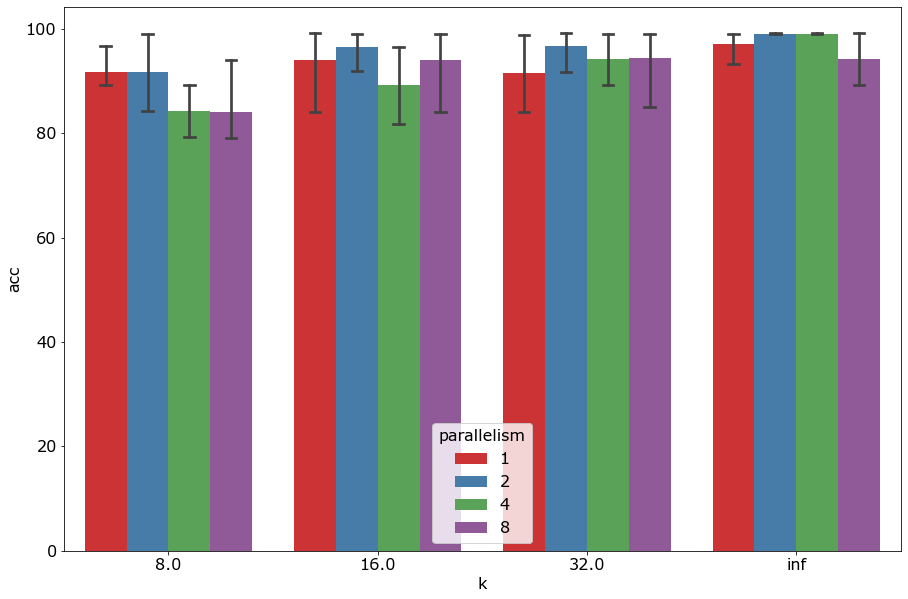

In [20]:
plt.rc('font', size=16)
plt.figure(figsize=(15,10))
sns.barplot(x='k', y='acc', data=df, capsize=.05, hue='parallelism')

# plt.savefig('./figures/resnet34/acc_per_k_and_parallelism.png', dpi=300)

#### Plot the time as a factor

<AxesSubplot:xlabel='parallelism', ylabel='time'>

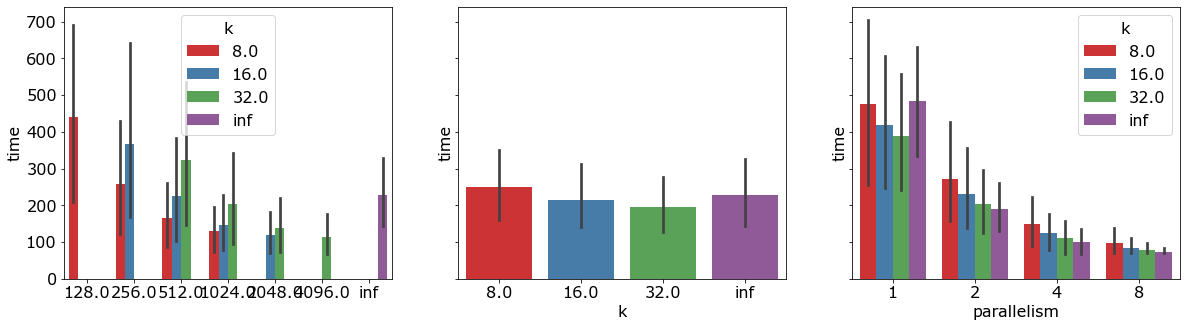

In [23]:
f, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 5))
sns.barplot(x='batch_size', y='time', hue='k', data=df, ax=ax[0])
sns.barplot(x='k', y='time', data=df, ax=ax[1])
sns.barplot(x='parallelism', y='time', data=df, ax=ax[2], hue='k')

# plt.savefig('./figures/resnet34/time.png', dpi=300)

plt.rc('font', size=16)
f, ax = plt.subplots(1, 3, figsize=(20,8), sharey=True)
sns.barplot(x='k', y='time', data=df.loc[df.batch_size==32], capsize=.05, hue='parallelism', ax=ax[0])
sns.barplot(x='k', y='time', data=df.loc[df.batch_size==64], capsize=.05, hue='parallelism', ax=ax[1])
sns.barplot(x='k', y='time', data=df.loc[df.batch_size==128], capsize=.05, hue='parallelism', ax=ax[2])

plt.savefig('./figures/resnet34/time_per_all.png', dpi=300)

In [ ]:
# Plot the validation lines of k=-1 and batch = 32 with different parallelism
def plot_loss_with_k_and_batch(k: int, batch:int, ax: plt.Axes = None):
    d = df.loc[(df.k==k) & (df.batch_size==batch)].sort_values(by='parallelism', ascending=False)

    plt.rc('font', size=13)
    if ax is None:
        f = plt.figure(figsize=(10, 5))
        for _, row in d.iterrows():
#             print(row.accuracy)
            plt.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.parallelism))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Accuracy evolution with LeNet (batch={batch}, k={k})')
        plt.legend(title='parallelism', bbox_to_anchor=(1.05, 0.8))
        
    else:
        for _, row in d.iterrows():
#             print(row.accuracy)
            ax.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.parallelism))
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title(f'Batch={batch}, k={k}')
        ax.legend(title='parallelism')
        

f, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15), sharex=True)

plt.suptitle('Behavior of K, Parallelism and Batch in Accuracy')

plot_loss_with_k_and_batch(k=8, batch=32, ax=axes[0][0])
plot_loss_with_k_and_batch(k=16, batch=32, ax=axes[0][1])   
plot_loss_with_k_and_batch(k=64, batch=32, ax=axes[0][2])
    
plot_loss_with_k_and_batch(k=8, batch=64, ax=axes[1][0])
plot_loss_with_k_and_batch(k=16, batch=64, ax=axes[1][1])   
plot_loss_with_k_and_batch(k=64, batch=64, ax=axes[1][2])

plot_loss_with_k_and_batch(k=8, batch=128, ax=axes[2][0])
plot_loss_with_k_and_batch(k=16, batch=128, ax=axes[2][1])   
plot_loss_with_k_and_batch(k=64, batch=128, ax=axes[2][2])


# plt.savefig('./figures/accuracy_study.png', dpi=300)


#### Keep Parallelism and batch set, vary K

#### Keep K and Batch set, vary parallelism

In [ ]:
# Plot the validation lines of k=-1 and batch = 32 with different parallelism
def plot_loss_with_k_and_batch(k: int, batch:int, ax: plt.Axes = None):
    d = df.loc[(df.k==k) & (df.batch_size==batch)].sort_values(by='parallelism', ascending=False)

    plt.rc('font', size=13)
    if ax is None:
        f = plt.figure(figsize=(10, 5))
        for _, row in d.iterrows():
#             print(row.accuracy)
            plt.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.parallelism))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Accuracy evolution with LeNet (batch={batch}, k={k})')
        plt.legend(title='parallelism', bbox_to_anchor=(1.05, 0.8))
        
    else:
        for _, row in d.iterrows():
#             print(row.accuracy)
            ax.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.parallelism))
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title(f'Batch={batch}, k={k}')
        ax.legend(title='parallelism')
        

f, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15), sharex=True)

plt.suptitle('Behavior of K, Parallelism and Batch in Accuracy')

plot_loss_with_k_and_batch(k=8, batch=32, ax=axes[0][0])
plot_loss_with_k_and_batch(k=16, batch=32, ax=axes[0][1])   
plot_loss_with_k_and_batch(k=64, batch=32, ax=axes[0][2])
    
plot_loss_with_k_and_batch(k=8, batch=64, ax=axes[1][0])
plot_loss_with_k_and_batch(k=16, batch=64, ax=axes[1][1])   
plot_loss_with_k_and_batch(k=64, batch=64, ax=axes[1][2])

plot_loss_with_k_and_batch(k=8, batch=128, ax=axes[2][0])
plot_loss_with_k_and_batch(k=16, batch=128, ax=axes[2][1])   
plot_loss_with_k_and_batch(k=64, batch=128, ax=axes[2][2])


# plt.savefig('./figures/accuracy_study.png', dpi=300)


#### Keep Parallelism and batch set, vary K

In [ ]:
# Plot the validation lines of k=-1 and batch = 32 with different parallelism
def plot_loss_with_parallelism_and_batch(p: int, batch:int, ax: plt.Axes = None):
    d = df.loc[(df.parallelism==p) & (df.batch_size==batch)].sort_values(by='k', ascending=False)
    
    approx_k = (60000/p)/batch

    plt.rc('font', size=16)
    if ax is None:
        f = plt.figure(figsize=(10, 5))
        for _, row in d.iterrows():
#             print(row.accuracy)
            plt.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.k))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Accuracy evolution with LeNet (batch={batch}, k={k})')
        plt.legend(title='parallelism', bbox_to_anchor=(1.05, 0.8))
        
    else:
        for _, row in d.iterrows():
            label = str(row.k) if row.k != float('inf') else f'{row.k} ({int(approx_k)})'
            ax.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=label)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title(f'Batch={batch}, Parallelism={p}')
        ax.legend(title='k')
        

f, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 20), sharex=True)

plt.suptitle('Behavior of K, Parallelism and Batch in Accuracy')

plot_loss_with_parallelism_and_batch(p=2, batch=32, ax=axes[0][0])
plot_loss_with_parallelism_and_batch(p=4, batch=32, ax=axes[0][1])   
plot_loss_with_parallelism_and_batch(p=8, batch=32, ax=axes[0][2])

plot_loss_with_parallelism_and_batch(p=2, batch=64, ax=axes[1][0])
plot_loss_with_parallelism_and_batch(p=4, batch=64, ax=axes[1][1])   
plot_loss_with_parallelism_and_batch(p=8, batch=64, ax=axes[1][2])

plot_loss_with_parallelism_and_batch(p=2, batch=128, ax=axes[2][0])
plot_loss_with_parallelism_and_batch(p=4, batch=128, ax=axes[2][1])   
plot_loss_with_parallelism_and_batch(p=8, batch=128, ax=axes[2][2])


plt.savefig('./figures/accuracy_study_varying_k.png', dpi=300)

#### Plot 3d dependencies between K and parallelism on time and accuracy

In [ ]:
# f, ax = plt.subplots(1, 2, projection='3d')

f = plt.figure()
ax = f.add_subplot(1, 2, 1, projection='3d')

from scipy.interpolate import griddata
X, Y = np.meshgrid(df.k.map(lambda v: 500 if v == float('inf') else v), df.parallelism)
Z = griddata((df.k.map(lambda v: 500 if v == float('inf') else v),
              df.parallelism),
              df.acc, (X, Y), method='cubic')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='coolwarm',
                       linewidth=0, antialiased=False)


In [ ]:
d = df.loc[df.batch==64]